# Onefootball churn prediction

Onefootball’s product is structured to target football fans of a specific team or league and provide them with a customized experience when consuming content and scores. The core of our platform is the Onefootball app, which sees up to millions of users every month. Customer turn-over is a core problem in the mobile ecosystem, especially for free apps like ours. The cost of acquiring new user can be lower or higher depending the market, but are strongly related to user churn in the long run. In this particular example we assume our marketing team has had major investments in Latin America (Peru, Paraguay & Bolivia).

<img src="https://cdn.greenhouse.io/external_greenhouse_job_boards/logos/000/009/874/original/Onefootball__RGB_green_.png?1504086699" width="400" height="400" />

#### Task

You have got a data sample of user's monthly activity between January and April 2018. Users could have joined our app between 2017-06-01 till 2018-04-30 which is represented in the first_install_date dimension. In addition to that you also know whether or not a user has a favourite team or not, how many sessions the user triggered in a month, as well as how many articles they read, how many matches they have accessed, predictions that have been set.
As mentioned before we want to predict churn of users und understand its main drivers. Specifically you should:

-  Estimate the number of returning & churned users for May 2018. You should create a table with 2 columns: user_id, exp_user_type that is stored in user_classified.csv
-  What are the main factors that drive user churn? Do they make sense? Discuss your findings.
-  In case you could add an additional variable to this data set that could help explain churn, which one would it be and why?



In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Reading in the assignment dataset
df = pd.read_csv('user_activity.csv')

# Showing the first few rows
df.head()

,month_at,user_id,first_install_date,last_session_date,country,has_favourite_team,operating_system,session_count,matches_entered,articles_read,predictions_made
0,2018-01-01,b241b5e2a4478ee3552e483b0b917cb5,2017-10-10,2018-01-23,pe,True,iOS,4,6,1,NaN
1,2018-01-01,9b77b94463070a1c164b6b13c1b27d50,2017-09-19,2018-01-25,pe,True,Android,66,110,1,NaN
2,2018-01-01,113ca37a11d9e434ce4d8a5d7e8102e7,2017-08-20,2018-01-24,pe,True,Android,20,7,34,NaN
3,2018-01-01,681038dc5bc548f5d3dde3c7d37fc86c,2017-11-15,2018-01-28,pe,True,Android,11,9,8,NaN
4,2018-01-01,1420964dad5efdce0d38b0a287dbd054,2017-08-20,2018-01-10,pe,True,Android,11,10,2,NaN


### User data

The datasets contain information on 90,079 users who used the app between period of 2018-01 and 2018-04. This includes existing users as well as new users who installed the app during this period.

The table contains user activety with each row representing a month's activity.

|Feature|Description|Type|
|---|---|---|
|month_at| the month the activity of a user was tracked|string|
|user_id| id of a user. Unique over all users|string|
|first_install_date| the first day a user started using the app, it can only be between 2017-06-01 and 2018-04-30|string|
|last_session_date| last day of activity a user has had in a month|string|
|country| the country a user is in|string|
|has_favourite_team| whether or not a user has a favourite club|boolean|
|operating_system| the operating system of a user's device|string|
|session_count| the count of session the user has had in a month on the Onefootball app|integer|
|matches_entered| the number of times a users accessed a game within a month|integer|
|articles_read| the number of times a users read an article within a month|integer|
|predicition_made| the number of times a users predicted a game within a month|float|

### What is churn?


In broad terms, churn is user inactivity. However, it is a vague term that is defined in various ways depending on the use case. In the case of this assignment, I will define a churned user as a user that has no activity in the last month or a user that downloads the app in the final month, and doesn't use it after the day of installation. Therefore I will be investigating the causes of this behaviour and, develop an model that will accurately predict whether a user will 'churn' based on their behaviour and demographics.

### Identifying 'churn' users

In [2]:
# Convert date features to datetime data types
df['month_at'] = pd.to_datetime(df['month_at'])
df['first_install_date'] = pd.to_datetime(df['first_install_date'])
df['last_session_date'] = pd.to_datetime(df['last_session_date'])

In [3]:
# Calculate the time between install and last use and concery to a numeric value
df['days_on_app'] =  df['last_session_date'] - df['first_install_date']
df['days_on_app'] = df['days_on_app'].map(lambda x: x.days)
df['days_on_app'] = df['days_on_app'].map(lambda x: 0 if x < 0 else x)

# Extract the month from the month_at feature and year from the first_install_date feature
df['last_session_month'] = pd.DatetimeIndex(df['last_session_date']).month
df['first_install_year'] = pd.DatetimeIndex(df['first_install_date']).year

In [4]:
# Group dataframe by userid with means for session_count, matches_entered, 
grouped_df = df.groupby('user_id', as_index=False).agg({'session_count': 'mean', 
                                                        'has_favourite_team': 'mean', 
                                                        'matches_entered': 'mean',
                                                        'articles_read': 'mean', 
                                                        'predictions_made': 'mean', 
                                                        'days_on_app': 'max', 
                                                        'last_session_month': 'max', 
                                                        'first_install_year': 'max', 
                                                        'country': 'max', 
                                                        'operating_system': 'max'})

# Transform the list to a DataFrame
grouped_df = pd.DataFrame(grouped_df)

# Showing the first few rows
grouped_df.head()

,user_id,has_favourite_team,operating_system,matches_entered,country,last_session_month,first_install_year,days_on_app,session_count,predictions_made,articles_read
0,00003f6f77ac0552e2aa0bf59a405913,True,iOS,7.00,pe,4,2018,0,1.0,NaN,1.0
1,0000c4f5df0883d4bbe23f41d6ea4eb1,True,Android,68.50,pe,4,2018,35,31.0,11.00,57.5
2,0000c5f2efec35f3b417c82b4b298604,True,Android,1.00,pe,4,2018,10,15.0,NaN,2.0
3,0000d8fbc7d9bee3df331380c2cdc35e,True,Android,2.00,pe,1,2017,136,13.0,2.00,5.0
4,000250a17706cebdd16112a4eec4c9ca,True,Android,67.75,bo,4,2018,91,32.5,2.25,7.0


In [5]:
# Calculate whether a user has churned
grouped_df['churned'] = np.where((grouped_df['last_session_month'] !=4) | (grouped_df['last_session_month'] == 1), 1, 0)

# Look at the number of churned users
grouped_df.churned.value_counts()

1    45120
0    44959
Name: churned, dtype: int64

From the above we have identified that approximately half of the users have churned, I will save these clasified users to a new dataset.

In [6]:
# Create dataframe with only user_id and churned
user_classified = grouped_df[['user_id', 'churned']]

# Rename churned to exp_user_type
user_classified.rename(columns={'churned':'exp_user_type'}, inplace=True)

# Save dataframe as user_classified.csv
user_classified.to_csv('user_classified.csv')

/Users/conorhickey/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### Distribution of churn for different features

#### First year of app installation

We will look at the proportion of users that churned based on the year that they installed the app.

In [7]:
# Define function for plotting proportion of churn by year of install
def plot_install_for_churn(plot_data):
    
    # bar chart 
    fp = sns.factorplot(x='first_install_year', y='churned', data=plot_data, kind='bar')
    sns.plt.title('Churn Rates by Year of Install')

    fp.set_xticklabels(['2017 ','2018'])
    fp.set_ylabels('Churn Rate')
    fp.set_xlabels('')
    plt.show()

In [8]:
# Look at the number of churned users for each year of install
install_year = pd.pivot_table(grouped_df, values='user_id', index=['churned', 'first_install_year'], 
                                    aggfunc=lambda x: x.count())
install_year

churned  first_install_year
0        2017                  12348
         2018                  32611
1        2017                  14838
         2018                  30282
Name: user_id, dtype: int64

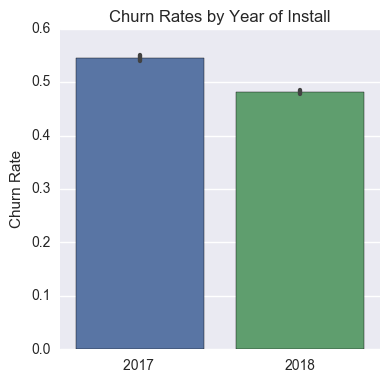

In [9]:
# Plot the proportion of churn for each year of install
plot_install_for_churn(grouped_df)

Users who installed the app in 2017 are more likely to churn, this could be because users who installed the app in 2018 are still geting used to the functionality.

#### Operating systems

We will now look at the the proportion users who churn who own either an andriod or iOS device.

In [10]:
# Define function for plotting proportion of churn for operating systems
def plot_os_for_churn(plot_data):
    
    # bar chart 
    fp = sns.factorplot(x='operating_system', y='churned', data=plot_data, kind='bar')
    sns.plt.title('Churn Rates for Operating Systems')

    fp.set_xticklabels(['iOS ','Android'])
    fp.set_ylabels('Churn Rate')
    fp.set_xlabels('')
    plt.show()

In [11]:
# Look at the number of churned users for each operating system
operating_systems = pd.pivot_table(grouped_df, values='user_id', index=['churned', 'operating_system'], 
                                    aggfunc=lambda x: x.count())
operating_systems

churned  operating_system
0        Android             39157
         iOS                  5802
1        Android             41021
         iOS                  4099
Name: user_id, dtype: int64

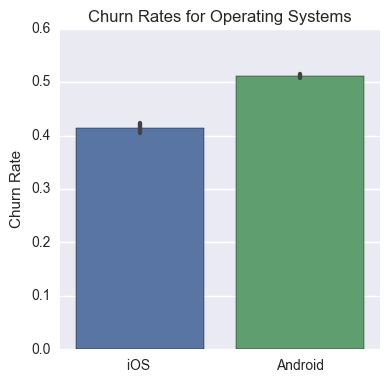

In [12]:
# Plot the proportion of churn for each operating system
plot_os_for_churn(grouped_df)

There are a larger number of users owning an android device and they also have a higher likelyhood of churning. This could be due to the functionality of the android app and could warrent further investigation.

#### Country

Finally we will will look at the churn rate for users in ech of the three countries.

In [13]:
# Define function for plotting churn rates for each country
def plot_categorical_churn_bar(bar_data, title, width=0.35, label_0='active', label_1='churned'):
    fig, ax = plt.subplots(figsize=(20,7))   
    
    # Set data 
    active_counts = bar_data[0].values
    churn_counts = bar_data[1].values
    ind = np.arange(len(active_counts))  # the x locations for the groups

    # Bar graphs for both groups 
    rects1 = ax.bar(ind, active_counts, width, color='r')
    rects2 = ax.bar(ind + width, churn_counts, width, color='y')

    # Add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Users')
    ax.set_title(title + '\n')
    
    # Calc xticks and set labels 
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(bar_data.index.levels[1].values)

    ax.legend((rects1[0], rects2[0]), (label_0, label_1))

    def autolabel(rects):
       
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

In [14]:
# Look at the number of churned users for each operating system
countries_for_plot = pd.pivot_table(grouped_df, values='user_id', index=['churned', 'country'], 
                                    aggfunc=lambda x: x.count())
countries_for_plot

churned  country
0        bo          8299
         pe         32604
         py          4056
1        bo          7367
         pe         33323
         py          4430
Name: user_id, dtype: int64

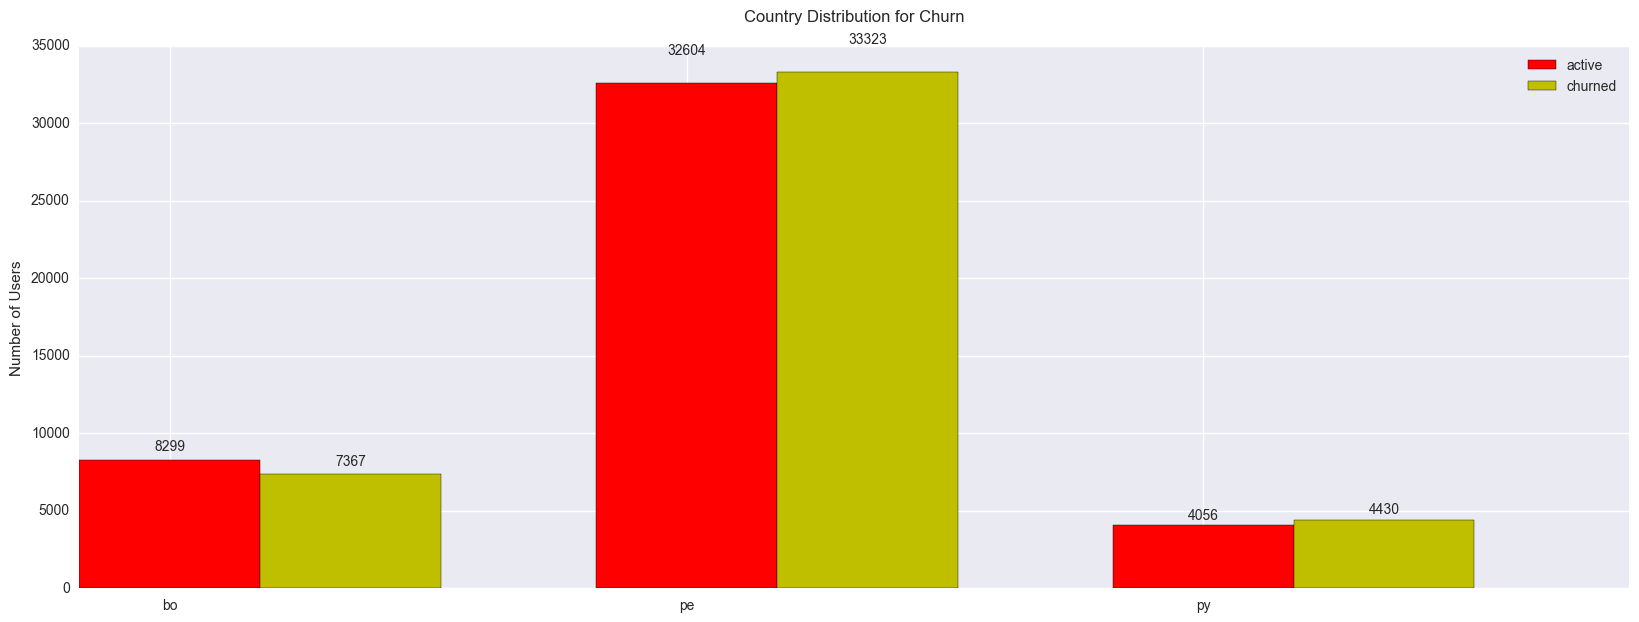

In [15]:
# Plot the churn rates for each country
plot_categorical_churn_bar(countries_for_plot, 'Country Distribution for Churn')

In Peru and Paraguay there is a slightly higher number of users who have churned, the reverse is true in Bolivia. This could be due to marketing efforts being different in each region.

### Feature engineering

In [16]:
# Convert NaN values to 0
grouped_df.fillna(0, inplace=True)

# Change boolean to integer
grouped_df.has_favourite_team = grouped_df.has_favourite_team.astype(int)

# Generate dummy variables from catagorical variables
dummy_df = pd.get_dummies(grouped_df, columns=['operating_system','country'])

In [17]:
# Scale the numerical variables
columns = ['matches_entered', 'days_on_app', 'session_count', 'predictions_made', 'articles_read']
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(grouped_df[columns])
scaled_df = pd.DataFrame(scaled_df, columns=columns)

In [18]:
# Define feature and target variables
y = dummy_df.churned
X = pd.concat([scaled_df, dummy_df[['has_favourite_team', 'operating_system_Android', 
                                      'operating_system_iOS', 'country_bo', 'country_pe', 
                                      'country_py']]], axis=1)

In [19]:
print 'Features shape: ' + str(X.shape)
print 'Target shape: ' + str(y.shape)

Features shape: (90079, 11)
Target shape: (90079,)


In [20]:
print 'Baseline accuracy: ' + str(len(dummy_df[dummy_df['churned'] == 0]) / float(len(dummy_df)))

Baseline accuracy: 0.49910633999


In [21]:
# Create dataframe for recoring results
results = pd.DataFrame(columns=['model','precision','recall','accuracy'])

# Calculate the baseline and add to dataframe
baseline = len(dummy_df[dummy_df['churned'] == 0]) / float(len(dummy_df))
results.loc[0,:] = ['baseline', np.nan, np.nan, baseline]

# Display the results dataframe
results

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.499106


### Heatmap

In [22]:
# Define a function to build a heat map
def corr_heatmap(data, width, height):
    data_corr = data.corr()

    mask = np.zeros_like(data_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=(width,height))
    ax = sns.heatmap(data_corr, mask=mask)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()

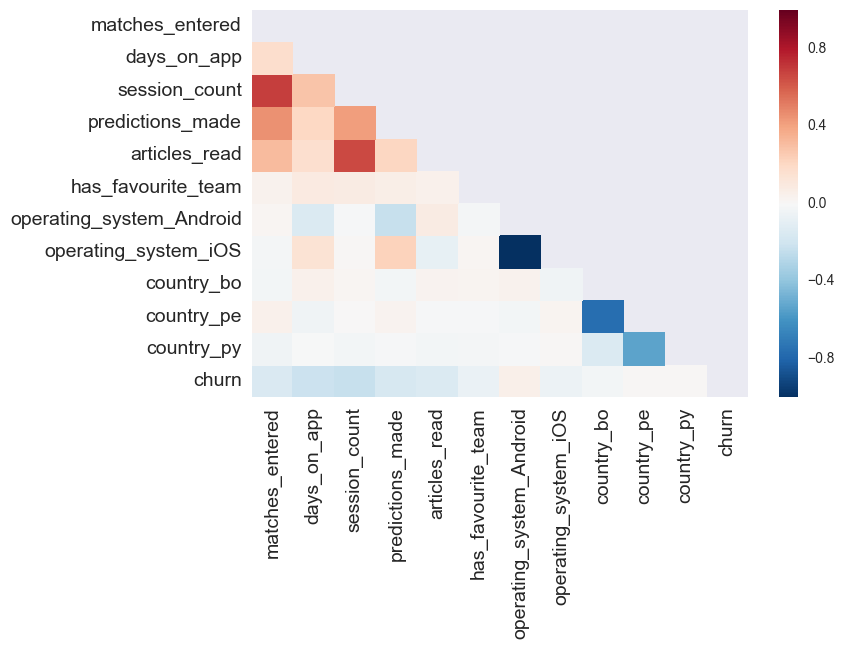

In [23]:
# Plot te heatmap
h_data = X.copy()
h_data['churn'] = y
corr_heatmap(h_data, 8, 5)

- There is a strong correlation between users who make predictions and the number of sessions that they register. This correlation with number of sessions is also strong for articles read, matches entered.
- No feature has a strong correlation with the target variable, this would indicate that there will not be a very large improvement on the baseline.

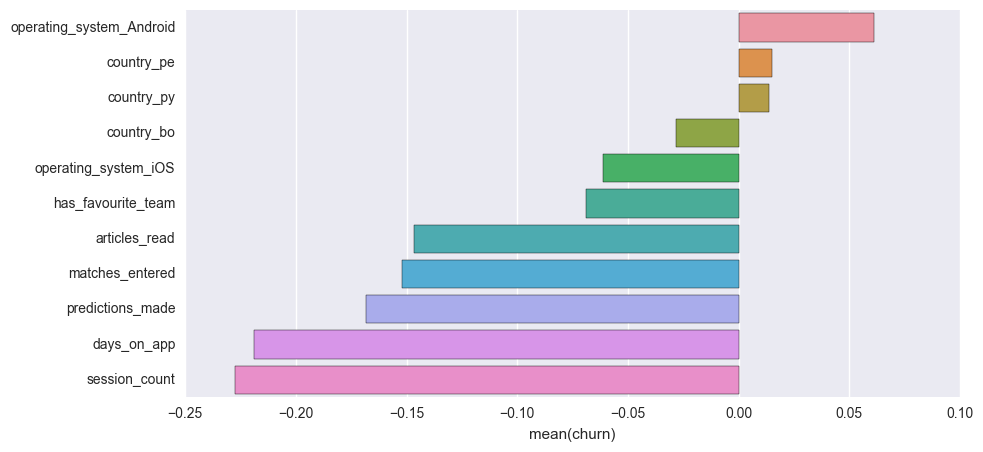

In [24]:
# Plot the correlated features
churn_corr = h_data.corr()['churn'].drop('churn').sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=churn_corr, y=churn_corr.index)
plt.show()

- Users with Android operating system are correlated with higher churn. 
- Session count, predictions made, articles read and matches entered have a high inverse correlation with churn and this is not suprising as it needs a high time investment in the app.
- Peru and Paraguay look like a good targets for launching more marketing campaigns.

### Modelling

In [25]:
# Importing feature manipulation libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Importing models libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Importing evaluation libraries
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score,\
recall_score, precision_recall_curve, average_precision_score, accuracy_score, f1_score

# Importing additional libraries
import time
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Logistic regression

In [26]:
# Define a function to gridsearch a logistic regression model
def gridsearch_lr_model(params, X=X):
    
    start = time.time()
    model = LogisticRegression(random_state=42) 
    lr_grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='precision')
    lr_grid = lr_grid.fit(X, y)    
    end = time.time()
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", lr_grid.best_params_
    print 'Best precision score: \n', lr_grid.best_score_
    return lr_grid

In [27]:
# Create a dictionary with the gridsearch parameters
params = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
          'penalty': ['l1','l2']}

# Call the model function
lr_grid = gridsearch_lr_model(params)

/Users/conorhickey/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model fit time in seconds: 
201.46360898
Best params: 
{'penalty': 'l1', 'C': 10}
Best precision score: 
0.611935234205


In [28]:
# Define a function to calculate model scores
def model_scores(model_grid, model_name, X=X, y=y):
    
    accuracy = cross_val_score(model_grid.best_estimator_, X, y, scoring='accuracy', cv=5)
    precision = cross_val_score(model_grid.best_estimator_, X, y, scoring='precision', cv=5)
    recall = cross_val_score(model_grid.best_estimator_, X, y, scoring='recall', cv=5)

    results.loc[len(results),:] = [model_name, np.mean(precision), np.mean(recall), np.mean(accuracy)]
    return results

# Call the model scoring function
model_scores(lr_grid, 'logistic regression')

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.499106
1,logistic regression,0.611935,0.711082,0.629414


There is an improvement in accuracy over the baseline. This was expected we are looking at various factors that can cause churn. Improvements on prediction accuracy and precision could be made by engineering and obtaining new features. However, there are some factors that we cannot track such as the motivation for using the app, personal circumstances etc.

In [29]:
# Create dataframe with the feature coeffecients
coefs_vars = pd.DataFrame({ 
    'coef':lr_grid.best_estimator_.coef_[0],
    'variable':X.columns,
    'abscoef':np.abs(lr_grid.best_estimator_.coef_[0]) 
})

In [30]:
# Display the coeffecients dataframe
coef_vars = coefs_vars.sort_values('abscoef', ascending=False)
coef_vars

,abscoef,coef,variable
3,10.550470,-10.550470,predictions_made
2,2.438641,-2.438641,session_count
1,1.442206,-1.442206,days_on_app
0,0.566962,0.566962,matches_entered
6,0.488195,0.488195,operating_system_Android
10,0.417989,0.417989,country_py
5,0.385267,-0.385267,has_favourite_team
9,0.380576,0.380576,country_pe
7,0.373686,0.373686,operating_system_iOS
8,0.274904,0.274904,country_bo


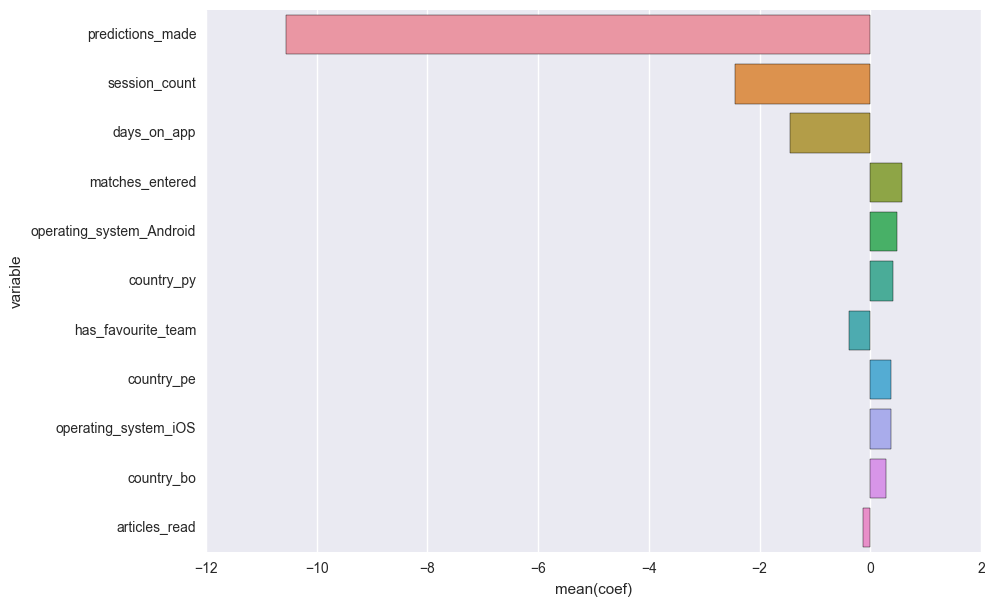

In [31]:
# Plot the feature coeffecients
fig = plt.figure(figsize=(10,7))
sns.barplot(x='coef', y='variable', data=coef_vars)
plt.show()

Feature coefficients are similar to the churn-correlation plot above. Logistic regression simply takes correlations into account in the same way and imposes regularization to improve variance.

#### Decision tree

In [32]:
# Convert catagorical variables to integers through Label Encoder
X_fac = pd.concat([scaled_df, grouped_df[['has_favourite_team', 'operating_system', 'country']]], axis=1)

# Define elabel encoder
le = LabelEncoder() #label encoder factorises categorical strings to integers

# Encode catagorical features
X_fac['operating_system'] = le.fit_transform(grouped_df.ix[grouped_df.index,'operating_system'].values)
X_fac['country'] = le.fit_transform(grouped_df.ix[grouped_df.index,'country'].values)

# Showing the first few rows
X_fac.head()

,matches_entered,days_on_app,session_count,predictions_made,articles_read,has_favourite_team,operating_system,country
0,0.012048,0.000000,0.000000,0.000,0.002016,1,1,1
1,0.135542,0.105105,0.151515,0.088,0.115927,1,0,1
2,0.000000,0.030030,0.070707,0.000,0.004032,1,0,1
3,0.002008,0.408408,0.060606,0.016,0.010081,1,0,1
4,0.134036,0.273273,0.159091,0.018,0.014113,1,0,0


In [33]:
print 'Features shape: ' + str(X_fac.shape)
print 'Target shape: ' + str(y.shape)

Features shape: (90079, 8)
Target shape: (90079,)


In [34]:
# Define function to gridsearch decision tree
def gridsearch_dt_model(params, X=X_fac):    

    start = time.time()
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(estimator=dt_model, param_grid=params, cv=5, scoring='precision')
    dt_grid = dt_grid.fit(X_fac, y)    
    end = time.time()
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", dt_grid.best_params_
    print 'Best precision score: \n', dt_grid.best_score_
    return dt_grid

In [35]:
# Create a dictionary with the gridsearch parameters
params = {'min_samples_leaf' : [1, 5, 10, 100, 500, 1000], 
           'max_depth': [1, 10, 100, 1000]}

# Call the model function
dt_model = gridsearch_dt_model(params)

Model fit time in seconds: 
30.9155550003
Best params: 
{'max_depth': 10, 'min_samples_leaf': 1000}
Best precision score: 
0.637351120278


In [36]:
# Further refine the gridsearch parameters
params = {'min_samples_leaf': range(500, 1500, 100),
          'max_depth': range(1, 20)}

# Call the model function
dt_model = gridsearch_dt_model(params)

Model fit time in seconds: 
176.322222948
Best params: 
{'max_depth': 3, 'min_samples_leaf': 500}
Best precision score: 
0.642336853942


The best parameters show that a low depth tree with high number of samples on the leaves gives the best precision score. This is due to having only a few variables correlating with churn and also small feature space in general.

In [37]:
# Call the model scoring function
model_scores(dt_model, 'decision tree', X=X_fac)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.499106
1,logistic regression,0.611935,0.711082,0.629414
2,decision tree,0.642337,0.6416,0.641504


Decision tree performance is slightly better than logistic regression. I expect substantial performance improvement for random forests.

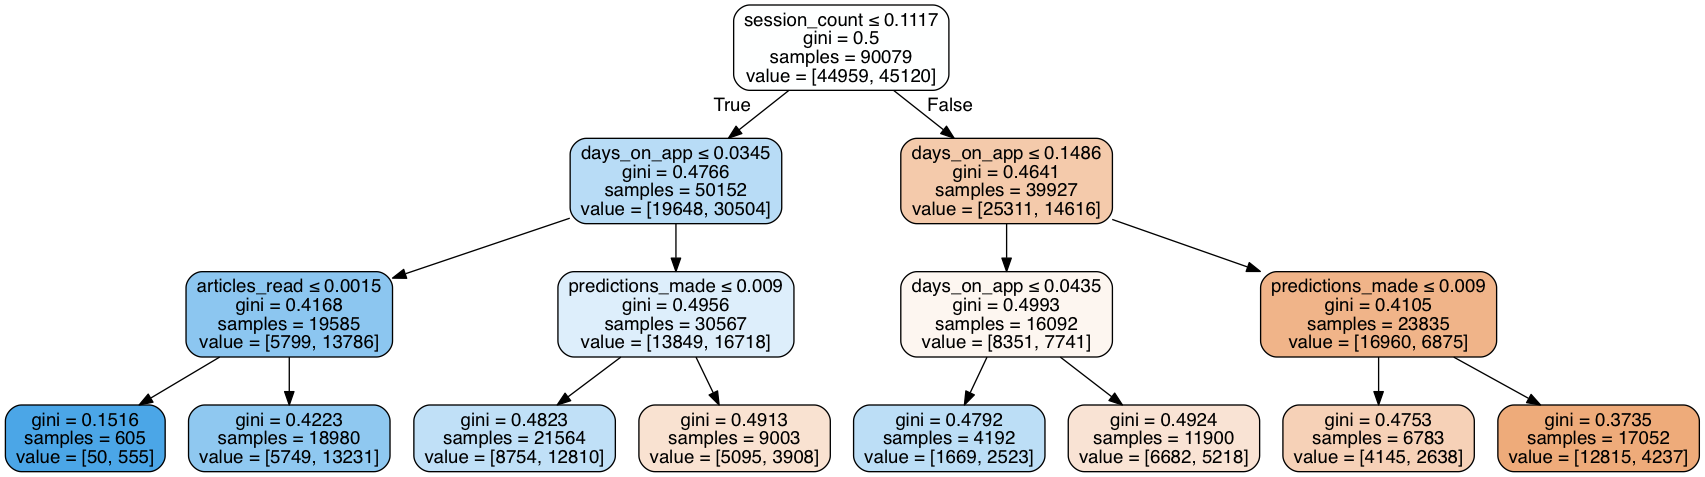

In [38]:
# Initialize the output file object
dot_data = StringIO() 

# Create and display the decision tree
export_graphviz(dt_model.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_fac.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We can see consistent results over both models. The decision tree is following the same prediction logic with logistic regression closely. The majority of the contributions for logistic regression is coming from the same 3 features. It is not surprising to see that the performances of both models are very close.

#### Random forests

In [39]:
# Define a function to gridsearch a RandomClassifier model
def gridsearch_rf_model(params, X=X_fac):
    
    start = time.time()
    rf_model = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(estimator=rf_model, param_grid=params, cv=5, scoring='precision')
    rf_grid = rf_grid.fit(X_fac, y)
    end = time.time()
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", rf_grid.best_params_
    print 'Best precision score: \n', rf_grid.best_score_

    return rf_grid

In [40]:
# Create a dictionary with the gridsearch parameters 
params = {'n_estimators':[1, 5, 10, 50, 75],
          'max_depth': [2, 10, 20, 30],
          'min_samples_leaf': [1, 3, 5, 20, 50, 100]
         }

# Call the model function
rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
1117.03736496
Best params: 
{'n_estimators': 75, 'max_depth': 10, 'min_samples_leaf': 20}
Best precision score: 
0.647383351533


In [42]:
# Call the model scoring function
model_scores(rf_grid, 'random forests', X=X_fac)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.499106
1,logistic regression,0.611935,0.711082,0.629414
2,decision tree,0.642337,0.6416,0.641504
3,random forests,0.647383,0.697828,0.658267


Random Forests outperforms both logistic regression and decision trees as expected. Best performance is achieved by generating large number of trees with few branches (small max depth). Since we are working with a small feature set with 5 columns this is normal. From feature importance observations earlier, there are only 3 features that are highly predictive. Random Forests achieve better performance by predicting through majority vote of large number of trees. It also reduces the variance by randomly assigning subset of features to branch splits.

It is also worth considering that improvement on precision comes with the price of deteriorated recall score. If the cost of false positives are higher than the value created by correctly predicting soon-to-churn users, random forests would be my pick.

### Understanding churn

I will now look for actionable insights by observing feature importances. Once we are able understand what is causing churn, it may be possible to redefine our product strategy and development roadmap.

#### Lasso regression

Lasso regularization (as used above) takes into account collinearities and lack of variance in features, imposes individual penalties on variables depending on their contribution to final prediction residues. 

I will be using lasso regression to see if any of the feature variable coefficients are drawn to 0. I will also use gridsearch for accuracy optimisation since I am interested in balanced predictions for the sake of meaningful feature coefficients.

In [43]:
# Create a dictionary with the gridsearch parameters 
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'penalty':['l1']
         }

# Define the model and perform Gridsearch
lr = LogisticRegression(random_state=42)
lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv=5, scoring='accuracy')
lr_gs = lr_gs.fit(X,y)

In [44]:
print 'best params: \n' + str(lr_gs.best_params_)
print 'best accuracy: \n' + str(lr_gs.best_score_)

best params: 
{'penalty': 'l1', 'C': 10}
best accuracy: 
0.629414180886


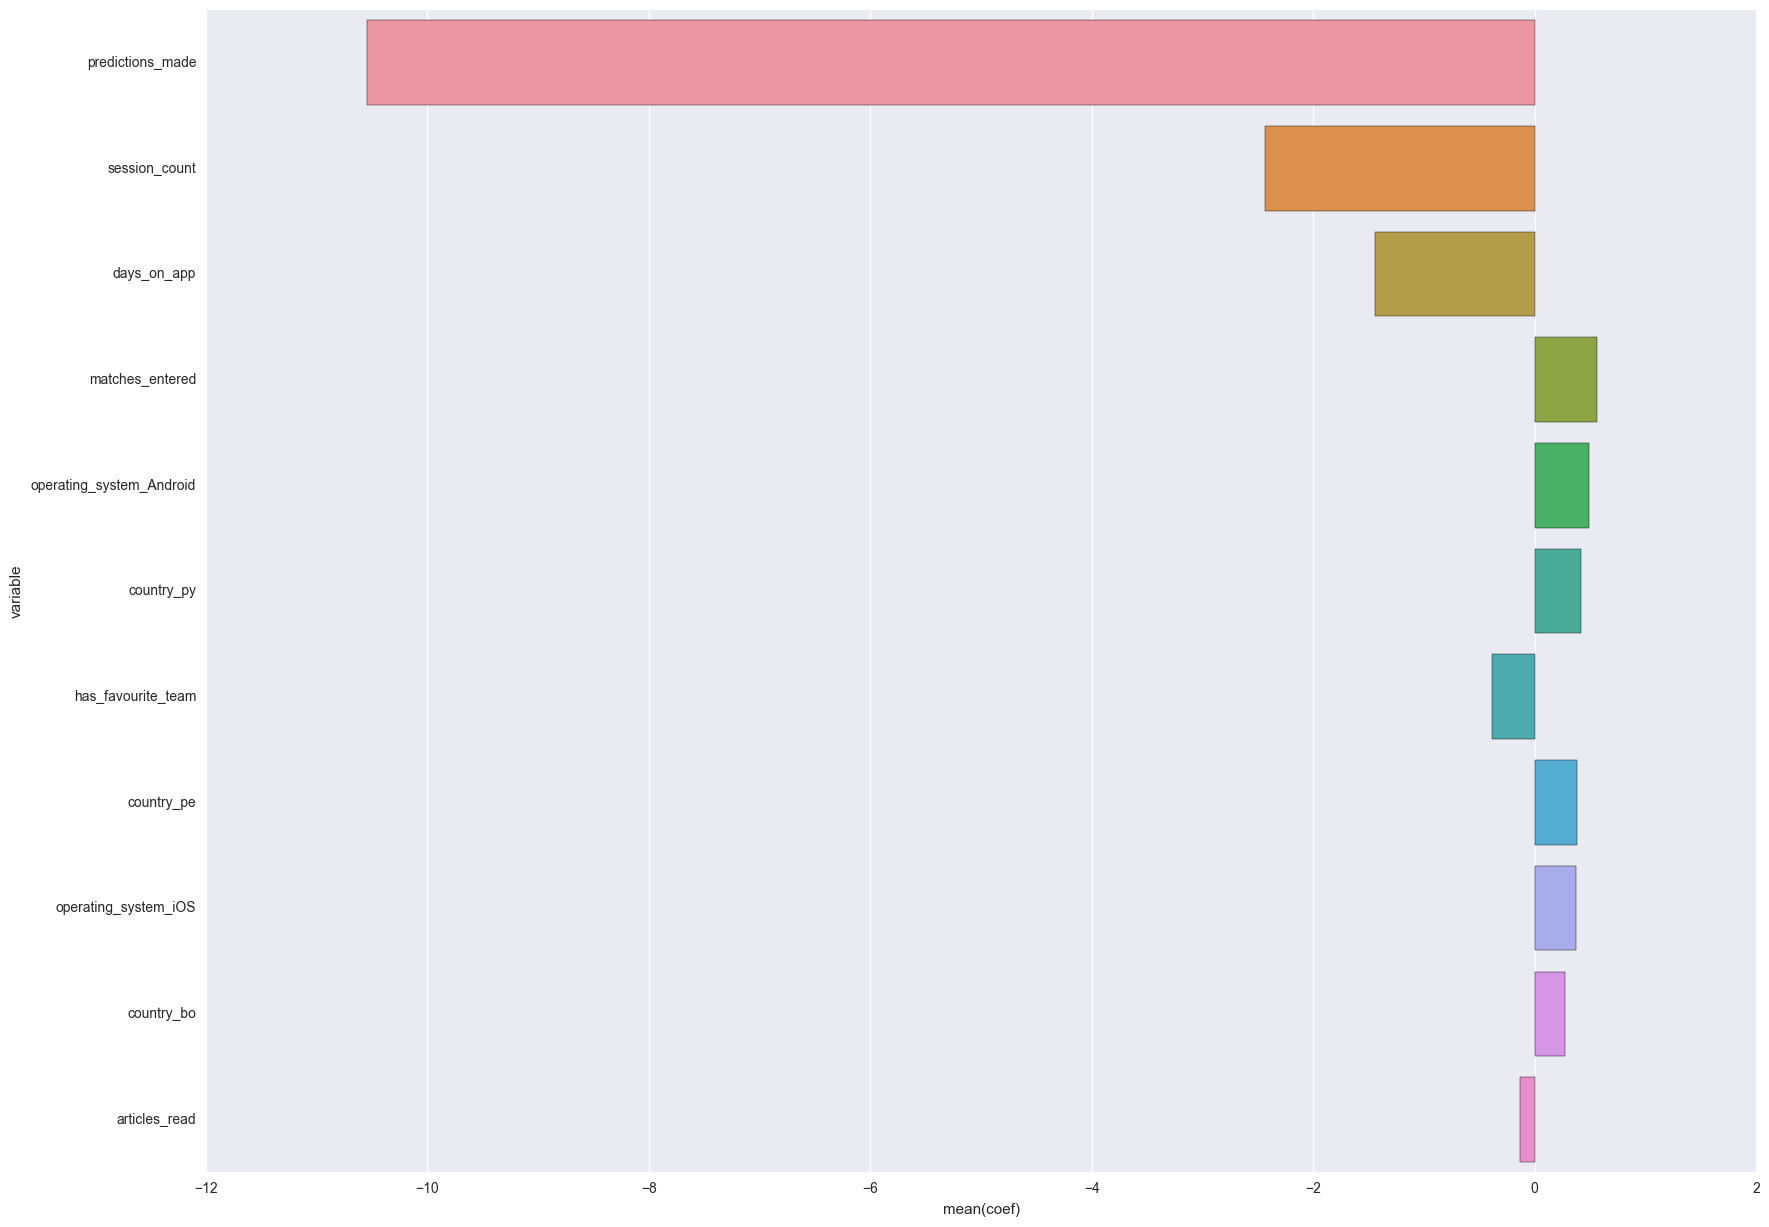

In [45]:
# Plot the feature coeffecients
coefs_vars = pd.DataFrame({
    'coef':lr_gs.best_estimator_.coef_[0],
    'variable':X.columns,
    'abscoef':np.abs(lr_gs.best_estimator_.coef_[0]) 
})
coefs_vars = coefs_vars.sort_values('abscoef', ascending=False)

fig = plt.figure(figsize=(20,15))
sns.barplot(x='coef', y='variable', data=coefs_vars)
plt.show()

### Summary

The Lasso Regression coefficient shown above explain a lot about which features are indicative of churn. We can analyse these features to help guide the strategy for reducing churn.

- We have observed that users with high engagement with the app are less likely to churn which is what we would expect. It may be useful to send push notifications to inactive users informing them of these features to increase engagement with the app.

- Users of the app on the Android operting system are more likely to churn so it would by informative to understand why. As it has a larger market share of the mobile opersting systems there is a higher diversity of software versions in use especially in Latin America. 

- We can see that churn is higher in Peru and Paraguay than it is in Bolivia, this is worth investigating further. Perhaps there are any additional features we can look at for analysis or looking to see if the marketing approach was consistant across all countries.

#### Next steps

- Split the dataset into training and test sets and compare the scores on each to ensure the models are not overfitting.
- Plot the performance with increasing training data size, to determine if we can increase performance over time as we acquire more users.
- Acquire additional features like app versions, operating system versions, lenght of session time (especially for churning users) to see if new factors can be identified for reducing churn.
- Look at different factors for identifying churn, 1-7 day is a common indicator or engineer new features for analysis.